# AI Investment Analyst

An agent that:

* Scrapes financial news + quarterly reports

* Runs sentiment analysis

* Combines with stock fundamentals

* Generates investment theses (bullish/bearish)

* Could integrate with Yahoo Finance API for real-time data.

# Imports

In [1]:
!pip install -U langgraph "langchain[openai]"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.3/153.3 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 447.5/447.5 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.7/216.7 kB 16.3 MB/s eta 0:00:00
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 0.3.75
    Uninstalling langchain-core-0.3.75:
      Successfully uninstalled langchain-core-0.3.75


In [2]:
!pip install -qU \
  langchain-core==0.3.33 \
  langchain-openai==0.3.3 \
  langchain-community==0.3.16
!pip install -U langchain pydantic

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 412.7/412.7 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 24.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.0/363.0 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 36.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
langgraph-prebuilt 0.6.4 requires langchain-core>=0.3.67, but you have langchain-core 0.3.33 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.4/68.4 kB 2.0 MB/s eta 0:00:00
  

In [3]:
!pip install langgraph

In [4]:
!pip install yfinance


In [52]:
from typing import Annotated, TypedDict, List, Dict, Any, Optional
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langchain_community.agent_toolkits import PlayWrightBrowserToolkit
from langchain_community.tools.playwright.utils import create_async_playwright_browser
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode,tools_condition
from langgraph.graph.message import add_messages
from pydantic import BaseModel, Field
from IPython.display import Image, display
import gradio as gr
import uuid
from dotenv import load_dotenv
import os
from langchain.agents import tool

# Set LangSmith

In [83]:
f=open("/content/Serper APIkey.txt","r")
smith_api_key=f.read()
os.environ["LANGCHAIN_API_KEY"] = smith_api_key
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "My-AI-Investor"

# Some Tools That My Model Should Use

In [7]:
f=open("/content/Serper APIkey.txt","r")
S_api_key=f.read()
os.environ["SERPER_API_KEY"] = S_api_key


In [8]:
from langchain_community.utilities import GoogleSerperAPIWrapper

serper = GoogleSerperAPIWrapper()

In [43]:
import yfinance as yf
@tool
def get_fin_data(ticker:str):
  """Find financial data about a stock"""
  stock = yf.Ticker(ticker)
  fin_data=stock.financials.to_dict()

  return fin_data




In [44]:


@tool
def search_news(query: str) -> str:
    """Search the web for financial news."""
    return serper.run(query)

tools=[search_news,get_fin_data]

# My Models

In [31]:

f=open("/content/OpenAIKey.txt","r")
api_key=f.read()



llm = ChatOpenAI(
    model_name="x-ai/grok-4-fast:free",
    openai_api_key=api_key,
    openai_api_base="https://openrouter.ai/api/v1",
    temperature=0.0)

In [45]:
llm=llm.bind_tools(tools)

# Let's Create Our Agent

* Create The State

In [137]:
#State
class Fin_State(TypedDict):
  ticker:str
  financials:str
  news:List[str]
  summary: str
  sentiment: str
  report :str


* Create Nodes

In [138]:
def fin_data_fetch(state:Fin_State)->Fin_State:
    prompt=ChatPromptTemplate.from_messages([
        ("system","You are an ai assistant that can use tools in order to find financial news and data about a stock."),
        ("user","Search online with the use of tools, in order to find financial news and data about the stock with ticker {ticker}")])

    chain_0=prompt|llm

    results = chain_0.invoke(state).content
    fin_data = str(results["financials"])
    news_items = []
    if "intermediate_steps" in results:
        for action, observation in results["intermediate_steps"]:
            if action.tool == "search_news":
                news_items.append(observation)

    return {**state, "financials": fin_data, "news": news_items}

In [139]:
def sum_fin_report(state:Fin_State)->Fin_State:
    prompt = ChatPromptTemplate.from_messages([
        ("system", "You are a financial analyst."),
        ("user", "Summarize the financial data:\n\n{financials}")])

    chain_1=prompt|llm

    summary=chain_1.invoke(state).content
    return {**state, "summary": summary}


In [140]:
def sentiment_analysis(state:Fin_State)-> Fin_State:
    prompt = ChatPromptTemplate.from_messages([
        ("system","You are a news sentiment analyst. You can classify if a news article is positive, neutral or negative."),
        ("user", "Analyze sentiment the following news article:\n\n{news}")])

    chain_2=prompt|llm

    sentiment=chain_2.invoke(state).content
    return {**state, "sentiment": sentiment}



In [141]:
def report_analyst(state:Fin_State)->Fin_State:
    prompt = ChatPromptTemplate.from_messages([
        ("system","""You are an ai investment strategist. Given some sentiment analysis and a summary of the financial data of a company, you can create an investment report.
        You help the user to deside if this company is a good investment oportunity or not"""),
        ("user", "Write an investment report combining:\n\n Summary : {summary} \n\n Sentiment:{sentiment}")])

    chain_3=prompt|llm
    report=chain_3.invoke(state).content
    return {**state, "report": report}



In [142]:
builder=StateGraph(Fin_State)

builder.add_node('data_fetch',fin_data_fetch)
builder.add_node('tools',ToolNode(tools=tools))
builder.add_node('sum_fin_report',sum_fin_report)
builder.add_node('sentiment_analysis',sentiment_analysis)
builder.add_node('report_analyst',report_analyst)

In [143]:

def my_tools_condition(state):
    next_node = tools_condition(state)
    if next_node == END:
        return "sum_fin_report"
    return next_node


In [144]:

builder.add_edge(START,'data_fetch')
builder.add_conditional_edges('data_fetch', my_tools_condition, ["tools", "sum_fin_report"])
builder.add_edge('tools','data_fetch')
builder.add_edge('data_fetch','sum_fin_report')
builder.add_edge('sum_fin_report','sentiment_analysis')
builder.add_edge('sentiment_analysis','report_analyst')
builder.add_edge('report_analyst',END)

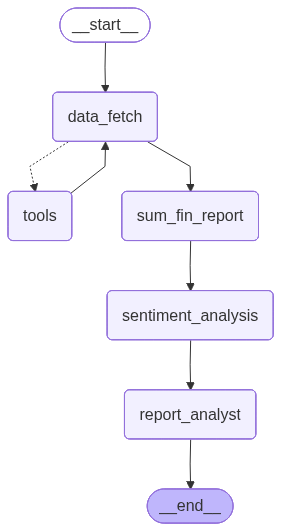

In [145]:
graph=builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [146]:
messages = graph.invoke({"ticker": 'GOOGL'})
for m in messages['messages']:
    m.pretty_print()

TypeError: string indices must be integers, not 'str'